# DER Integration and Advanced Applications

| Information | Details |
|----------|---------||
| Lead Author | Hantao Cui |
| Learning Objectives | • Integrate distributed energy resources in T&D co-simulation<br>• Implement solar PV and battery storage models<br>• Analyze reverse power flow scenarios<br>• Explore voltage regulation with high DER penetration<br>• Apply co-simulation to real-world grid challenges |
| Prerequisites | Lessons 3-4 (T&D co-simulation fundamentals and advanced topics) |
| Estimated Time | 120 minutes |
| Topics | DER modeling, solar PV integration, battery storage<br>Reverse power flow, voltage regulation, grid services |

In [1]:
# Environment check and setup
import sys
import importlib

print("Checking environment...")
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check for required packages
required_packages = {
    'numpy': 'NumPy',
    'pandas': 'Pandas',
    'matplotlib': 'Matplotlib',
    'helics': 'HELICS',
    'andes': 'ANDES',
    'opendssdirect': 'OpenDSSDirect'
}

missing_packages = []
for package, name in required_packages.items():
    try:
        importlib.import_module(package)
        print(f"✓ {name} is available")
    except ImportError:
        print(f"✗ {name} is NOT available")
        missing_packages.append(package)

if missing_packages:
    print(f"\nPlease install missing packages: {', '.join(missing_packages)}")
    print("Run: mamba install -c conda-forge " + ' '.join(missing_packages))
else:
    print("\n✓ All required packages are available!")

Checking environment...
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
Python executable: /home/hacui/mambaforge/envs/helics/bin/python3.9
✓ NumPy is available
✓ Pandas is available
✓ Matplotlib is available
✓ HELICS is available
✓ ANDES is available
✓ OpenDSSDirect is available

✓ All required packages are available!


## Introduction

The rapid growth of distributed energy resources fundamentally changes how power systems operate. Solar panels on rooftops, battery storage in garages, and electric vehicles in driveways transform traditionally passive distribution systems into active networks that can both consume and generate power. This transformation creates new challenges that require sophisticated analysis tools.

Traditional power system analysis assumed unidirectional power flow from large generators through transmission lines to distribution loads. DERs break this paradigm. A distribution feeder with high solar penetration might export power to the transmission system during sunny afternoons, then import power when clouds pass over or evening demand peaks. Understanding these bidirectional interactions requires co-simulation that captures both transmission system dynamics and distribution system details.

This lesson extends our T&D co-simulation framework to include DER models, exploring both technical challenges and grid service opportunities that emerge from the distributed energy transformation.

## DER Modeling Fundamentals

### Types of DERs and Their Characteristics

Distributed energy resources encompass various technologies, each with unique operational characteristics that affect grid integration. Solar photovoltaic systems produce power that varies with irradiance and temperature. Battery storage systems can absorb or inject power based on control signals. Combined heat and power units provide both electricity and thermal energy. Electric vehicles present mobile loads that can potentially provide grid services.

For co-simulation, we must capture the essential behaviors of these resources while maintaining computational tractability. This means choosing appropriate model fidelity for our analysis objectives.

Distributed Energy Resource Characteristics
        Resource Power_Range_kW Response_Time  Variability Grid_Services
        Solar PV         1-1000       Seconds         High        Energy
 Battery Storage         5-5000  Milliseconds Controllable      Multiple
    Wind Turbine       100-3000       Seconds         High        Energy
Electric Vehicle          3-150       Seconds    Scheduled V2G potential
       Fuel Cell          1-500       Minutes          Low        Energy


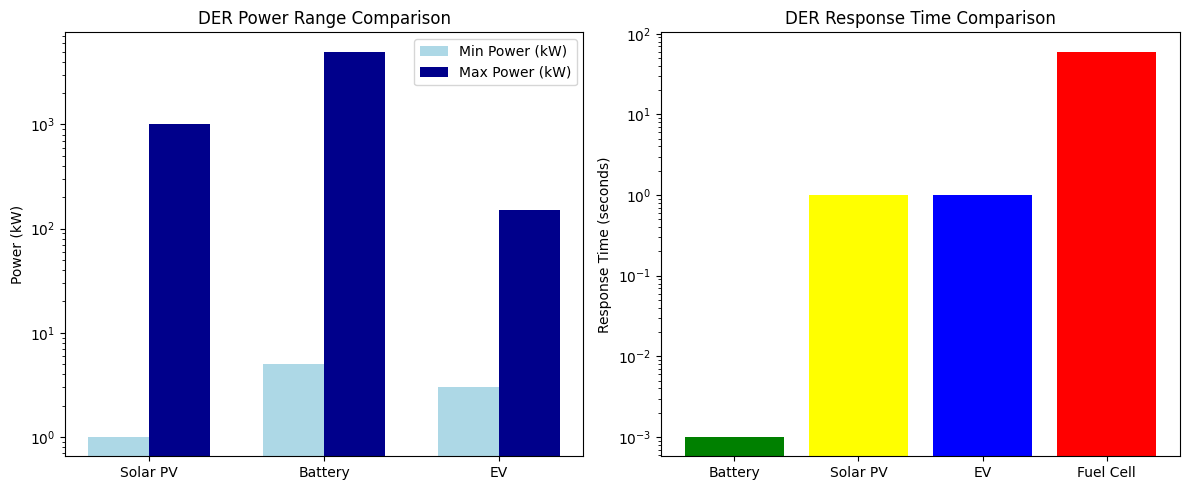

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import helics as h
import opendssdirect as dss

%matplotlib inline


# DER characteristics comparison
der_types = pd.DataFrame({
    'Resource': ['Solar PV', 'Battery Storage', 'Wind Turbine', 'Electric Vehicle', 'Fuel Cell'],
    'Power_Range_kW': ['1-1000', '5-5000', '100-3000', '3-150', '1-500'],
    'Response_Time': ['Seconds', 'Milliseconds', 'Seconds', 'Seconds', 'Minutes'],
    'Variability': ['High', 'Controllable', 'High', 'Scheduled', 'Low'],
    'Grid_Services': ['Energy', 'Multiple', 'Energy', 'V2G potential', 'Energy']
})

print("Distributed Energy Resource Characteristics")
print("=" * 60)
print(der_types.to_string(index=False))

# Visualize DER power capabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Power range comparison
resources = ['Solar PV', 'Battery', 'EV']
min_power = [1, 5, 3]
max_power = [1000, 5000, 150]

x = np.arange(len(resources))
width = 0.35

ax1.bar(x - width/2, min_power, width, label='Min Power (kW)', color='lightblue')
ax1.bar(x + width/2, max_power, width, label='Max Power (kW)', color='darkblue')
ax1.set_ylabel('Power (kW)')
ax1.set_title('DER Power Range Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(resources)
ax1.legend()
ax1.set_yscale('log')

# Response time comparison
response_times = {'Battery': 0.001, 'Solar PV': 1, 'EV': 1, 'Fuel Cell': 60}
ax2.bar(response_times.keys(), response_times.values(), color=['green', 'yellow', 'blue', 'red'])
ax2.set_ylabel('Response Time (seconds)')
ax2.set_title('DER Response Time Comparison')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

### Solar PV Modeling

Solar photovoltaic systems convert sunlight into electricity through semiconductor devices. For grid integration studies, we need models that capture the relationship between environmental conditions and power output while being computationally efficient for co-simulation.

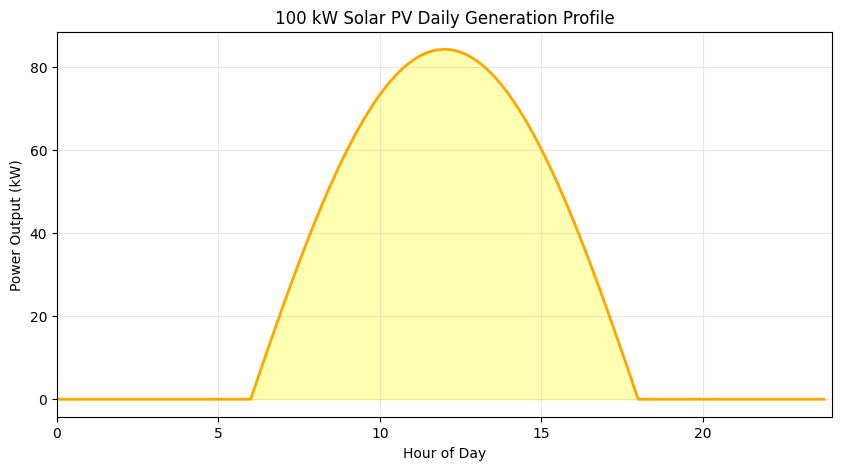

Daily energy generation: 162.3 kWh
Capacity factor: 27.1%


In [3]:
class SimpleSolarPV:
    """
    Simplified solar PV model for co-simulation studies.
    Captures essential behaviors without excessive detail.
    """
    
    def __init__(self, rated_kw, efficiency=0.20, temp_coeff=-0.004):
        """
        Initialize solar PV model.
        
        Parameters:
        rated_kw: Nameplate capacity in kW (at STC: 1000 W/m², 25°C)
        efficiency: Panel efficiency (typically 15-22%)
        temp_coeff: Temperature coefficient (%/°C, typically -0.4%/°C)
        """
        self.rated_kw = rated_kw
        self.efficiency = efficiency
        self.temp_coeff = temp_coeff
        self.area = rated_kw / (1.0 * efficiency)  # Approximate panel area
    
    def calculate_power(self, irradiance, temperature, time_of_day=None):
        """
        Calculate PV power output based on conditions.
        
        Parameters:
        irradiance: Solar irradiance (W/m²)
        temperature: Ambient temperature (°C)
        time_of_day: Hour (0-24) for simple shading effects
        
        Returns:
        power_kw: AC power output in kW
        """
        # Basic power calculation
        power_dc = self.area * irradiance * self.efficiency / 1000.0
        
        # Temperature derating
        cell_temp = temperature + 25  # Simple NOCT model
        temp_factor = 1 + self.temp_coeff * (cell_temp - 25)
        power_dc *= temp_factor
        
        # Inverter efficiency (simplified)
        if power_dc > 0:
            inverter_eff = 0.96 - 0.01 * (1 - power_dc/self.rated_kw)
            power_ac = power_dc * inverter_eff
        else:
            power_ac = 0
            
        # Limit to rated power
        power_ac = min(power_ac, self.rated_kw)
        
        return power_ac
    
    def create_daily_profile(self, peak_irradiance=1000):
        """
        Generate a typical daily generation profile.
        """
        hours = np.arange(0, 24, 0.25)
        
        # Simple irradiance model (clear day)
        irradiance = np.zeros_like(hours)
        daylight = (hours >= 6) & (hours <= 18)
        irradiance[daylight] = peak_irradiance * np.sin(np.pi * (hours[daylight] - 6) / 12)
        
        # Temperature varies during day
        temperature = 20 + 10 * np.sin(np.pi * (hours - 6) / 12)
        
        # Calculate power for each time
        power = [self.calculate_power(irr, temp) for irr, temp in zip(irradiance, temperature)]
        
        return hours, np.array(power)

# Demonstrate solar PV model
pv_100kw = SimpleSolarPV(rated_kw=100)
hours, power = pv_100kw.create_daily_profile()

plt.figure(figsize=(10, 5))
plt.plot(hours, power, 'orange', linewidth=2)
plt.fill_between(hours, 0, power, alpha=0.3, color='yellow')
plt.xlabel('Hour of Day')
plt.ylabel('Power Output (kW)')
plt.title('100 kW Solar PV Daily Generation Profile')
plt.grid(True, alpha=0.3)
plt.xlim(0, 24)
plt.show()

print(f"Daily energy generation: {np.trapezoid(power, hours/4):.1f} kWh")
print(f"Capacity factor: {np.mean(power)/100:.1%}")

### Battery Storage Modeling

Battery energy storage systems provide flexibility to the grid by storing excess energy and releasing it when needed. Unlike solar PV, batteries are controllable resources that can provide multiple grid services.

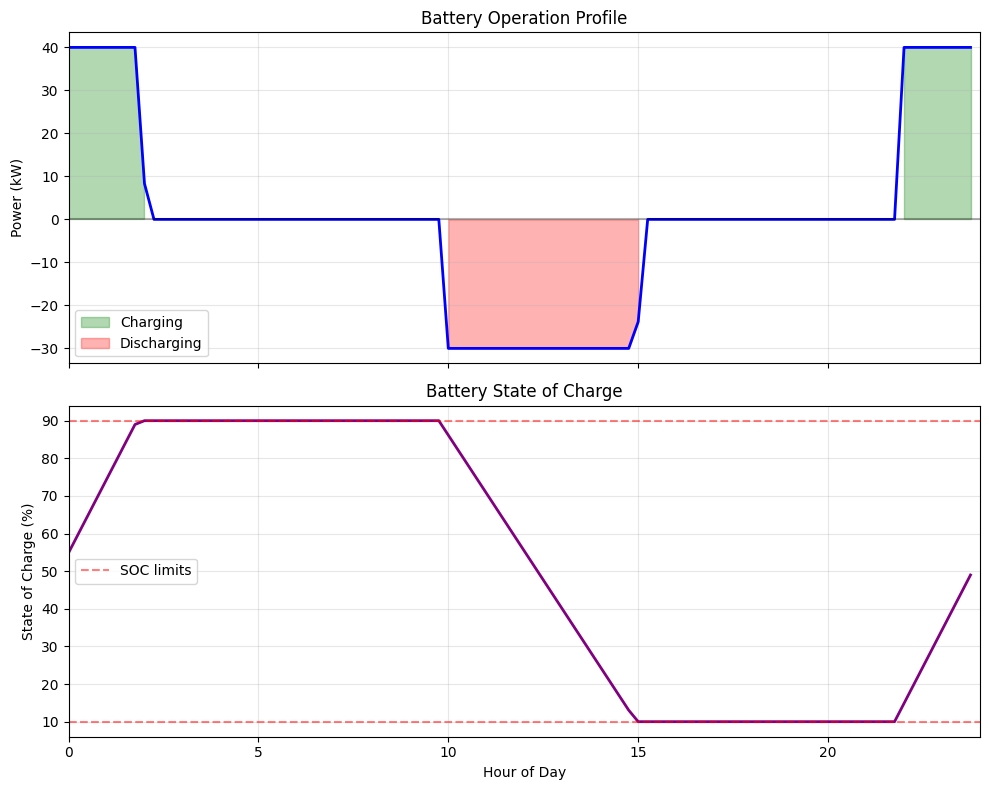

In [4]:
class SimpleBattery:
    """
    Simplified battery storage model for grid integration studies.
    """
    
    def __init__(self, power_kw, energy_kwh, efficiency=0.95, 
                 soc_min=0.1, soc_max=0.9):
        """
        Initialize battery model.
        
        Parameters:
        power_kw: Maximum charge/discharge power (kW)
        energy_kwh: Energy capacity (kWh)
        efficiency: Round-trip efficiency
        soc_min/max: State of charge limits
        """
        self.power_kw = power_kw
        self.energy_kwh = energy_kwh
        self.efficiency = efficiency
        self.soc_min = soc_min
        self.soc_max = soc_max
        self.soc = 0.5  # Initial SOC at 50%
    
    def charge_discharge(self, power_command, duration_hours):
        """
        Execute charge (positive) or discharge (negative) command.
        
        Returns:
        actual_power: Power delivered (limited by constraints)
        new_soc: State of charge after operation
        """
        # Limit power by rating
        power_limited = np.clip(power_command, -self.power_kw, self.power_kw)
        
        # Calculate energy change
        if power_limited > 0:  # Charging
            energy_change = power_limited * duration_hours * np.sqrt(self.efficiency)
        else:  # Discharging
            energy_change = power_limited * duration_hours / np.sqrt(self.efficiency)
            
        # Calculate new SOC
        soc_change = energy_change / self.energy_kwh
        new_soc = self.soc + soc_change
        
        # Apply SOC limits
        if new_soc > self.soc_max:
            new_soc = self.soc_max
            actual_energy = (new_soc - self.soc) * self.energy_kwh
            if power_limited > 0:
                actual_power = actual_energy / (duration_hours * np.sqrt(self.efficiency))
            else:
                actual_power = actual_energy * np.sqrt(self.efficiency) / duration_hours
        elif new_soc < self.soc_min:
            new_soc = self.soc_min
            actual_energy = (new_soc - self.soc) * self.energy_kwh
            if power_limited > 0:
                actual_power = actual_energy / (duration_hours * np.sqrt(self.efficiency))
            else:
                actual_power = actual_energy * np.sqrt(self.efficiency) / duration_hours
        else:
            actual_power = power_limited
            
        # Update SOC
        self.soc = new_soc
        
        return actual_power, self.soc
    
    def get_available_power(self):
        """
        Calculate available charge and discharge power based on SOC.
        """
        # Available energy for discharge
        energy_available_discharge = (self.soc - self.soc_min) * self.energy_kwh
        power_available_discharge = min(self.power_kw,
                                       energy_available_discharge * np.sqrt(self.efficiency))
        
        # Available energy for charge
        energy_available_charge = (self.soc_max - self.soc) * self.energy_kwh
        power_available_charge = min(self.power_kw,
                                    energy_available_charge / np.sqrt(self.efficiency))
        
        return power_available_charge, power_available_discharge

# Demonstrate battery operation
battery = SimpleBattery(power_kw=50, energy_kwh=200)

# Simulate daily operation
hours = np.arange(0, 24, 0.25)
power_commands = []
soc_values = []

for hour in hours:
    # Simple arbitrage strategy: charge at night, discharge during day
    if 0 <= hour < 6 or 22 <= hour < 24:
        command = 40  # Charge at night
    elif 10 <= hour < 20:
        command = -30  # Discharge during day
    else:
        command = 0  # Idle
    
    actual_power, soc = battery.charge_discharge(command, 0.25)
    power_commands.append(actual_power)
    soc_values.append(soc)

# Visualize battery operation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Power profile
ax1.plot(hours, power_commands, 'b-', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.fill_between(hours, 0, power_commands, where=np.array(power_commands)>0,
                  alpha=0.3, color='green', label='Charging')
ax1.fill_between(hours, 0, power_commands, where=np.array(power_commands)<0,
                  alpha=0.3, color='red', label='Discharging')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Battery Operation Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# SOC profile
ax2.plot(hours, np.array(soc_values)*100, 'purple', linewidth=2)
ax2.axhline(y=battery.soc_min*100, color='r', linestyle='--', alpha=0.5, label='SOC limits')
ax2.axhline(y=battery.soc_max*100, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('State of Charge (%)')
ax2.set_title('Battery State of Charge')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 24)

plt.tight_layout()
plt.show()

## Integrating DERs in T&D Co-simulation

Now we integrate DER models into our transmission-distribution co-simulation framework. The key challenge is properly representing DER impacts on both local distribution voltages and system-wide power flows.

Creating DER-enabled distribution system...


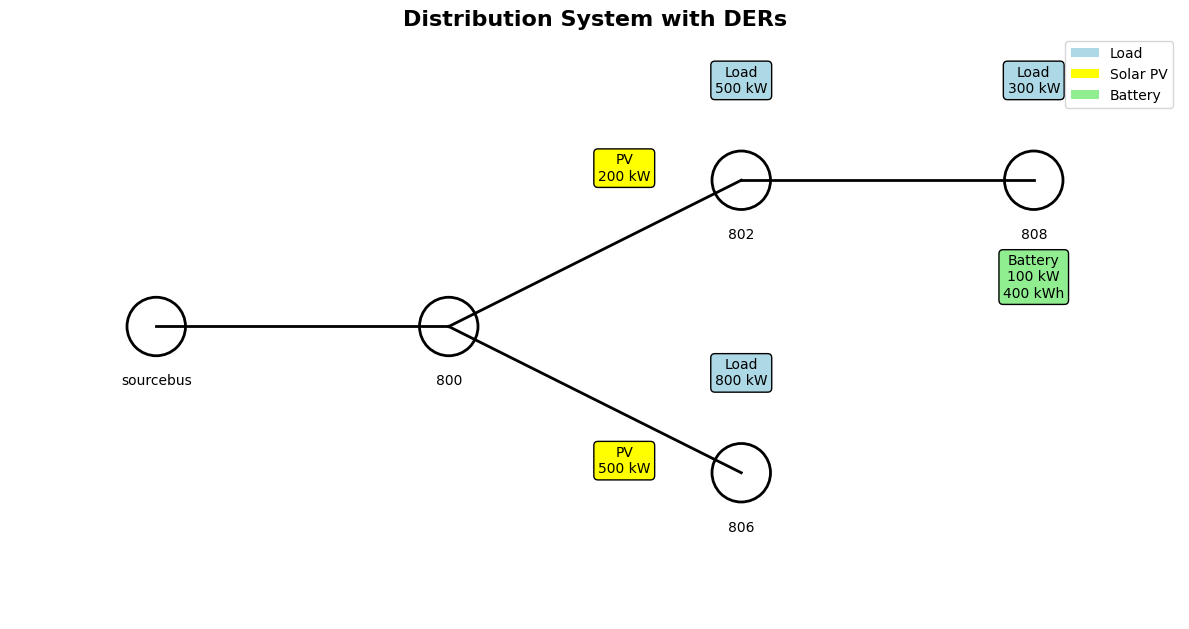


Initial System Conditions:
Total Load: 903.5 kW
Total Generation: 1000.0 kW
Net Import: -96.5 kW


In [5]:
def create_der_enabled_distribution_system():
    """
    Create a distribution system with integrated DERs.
    Based on IEEE 34-bus but with added solar and storage.
    """
    # Clear any existing circuit
    dss.Command('Clear')
    
    # Create base distribution system
    commands = [
        "New Circuit.DER_Test basekv=24.9 phases=3",
        
        # Simplified feeder
        "New Line.L1 bus1=sourcebus bus2=800 length=2 units=km",
        "New Line.L2 bus1=800 bus2=802 length=1 units=km",
        "New Line.L3 bus1=800 bus2=806 length=1.5 units=km",
        "New Line.L4 bus1=802 bus2=808 length=0.5 units=km",
        
        # Traditional loads
        "New Load.L1 bus1=802 kV=24.9 kW=500 kvar=100 model=1",
        "New Load.L2 bus1=806 kV=24.9 kW=800 kvar=200 model=1",
        "New Load.L3 bus1=808 kV=24.9 kW=300 kvar=80 model=1",
        
        # Solar PV systems
        "New Generator.PV1 bus1=802 kV=24.9 kW=200 pf=1.0 model=7",  # 200 kW at bus 802
        "New Generator.PV2 bus1=806 kV=24.9 kW=500 pf=1.0 model=7",  # 500 kW at bus 806
        
        # Battery storage
        "New Storage.Battery1 bus1=808 kWrated=100 kWhrated=400 %stored=50",
        
        # Voltage regulation
        "Set Voltagebases=[24.9]",
        "Calcvoltagebases"
    ]
    
    for cmd in commands:
        dss.Command(cmd)
    
    # Set control mode
    dss.Command("Set Mode=Snap")
    dss.Command("Set ControlMode=Static")
    
    return commands

def visualize_der_distribution():
    """
    Create a visual representation of the DER-enabled distribution system.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bus locations
    buses = {
        'sourcebus': (0, 0),
        '800': (2, 0),
        '802': (4, 1),
        '806': (4, -1),
        '808': (6, 1)
    }
    
    # Draw buses
    for bus, (x, y) in buses.items():
        circle = plt.Circle((x, y), 0.2, color='black', fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y-0.4, bus, ha='center', fontsize=10)
    
    # Draw lines
    lines = [
        ('sourcebus', '800'),
        ('800', '802'),
        ('800', '806'),
        ('802', '808')
    ]
    
    for bus1, bus2 in lines:
        x1, y1 = buses[bus1]
        x2, y2 = buses[bus2]
        ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)
    
    # Draw loads
    loads = {'802': 500, '806': 800, '808': 300}
    for bus, kw in loads.items():
        x, y = buses[bus]
        ax.text(x, y+0.6, f'Load\n{kw} kW', ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
    
    # Draw PV systems
    pvs = {'802': 200, '806': 500}
    for bus, kw in pvs.items():
        x, y = buses[bus]
        ax.text(x-0.8, y, f'PV\n{kw} kW', ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow'))
    
    # Draw battery
    x, y = buses['808']
    ax.text(x, y-0.8, 'Battery\n100 kW\n400 kWh', ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))
    
    # Add legend elements
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', label='Load'),
        Patch(facecolor='yellow', label='Solar PV'),
        Patch(facecolor='lightgreen', label='Battery')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_xlim(-1, 7)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Distribution System with DERs', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create and visualize the system
print("Creating DER-enabled distribution system...")
create_der_enabled_distribution_system()
visualize_der_distribution()

# Solve and show initial conditions
dss.Command("Solve")
print("\nInitial System Conditions:")
print(f"Total Load: {-dss.Circuit.TotalPower()[0]:.1f} kW")
print(f"Total Generation: {sum([dss.Generators.kW() for _ in range(dss.Generators.Count())]):.1f} kW")
print(f"Net Import: {-dss.Circuit.TotalPower()[0] - sum([dss.Generators.kW() for _ in range(dss.Generators.Count())]):.1f} kW")

## DER-Enhanced Co-simulation Implementation

We now implement a co-simulation that demonstrates how DERs affect both distribution system operation and transmission-distribution interactions. This includes modeling time-varying solar generation and battery dispatch strategies.

In [6]:
# Note: This cell demonstrates HELICS co-simulation concepts.
# In practice, this would require a running HELICS broker.
# For educational purposes, we show the code structure.

print("HELICS Co-simulation Code Structure:")
print("=" * 50)

def distribution_federate_with_ders(stop_time=24.0, scale_factor=20.0):
    """
    Distribution federate with time-varying DER operation.
    Demonstrates solar generation patterns and battery optimization.
    """
    print("[DER-DIST] Starting DER-enabled distribution federate...")
    
    # Create federate
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "DER_DistributionFederate")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.25)
    
    fed = h.helicsCreateValueFederate("DER_DistributionFederate", fedinfo)
    
    # Register interfaces
    pub_power = h.helicsFederateRegisterGlobalPublication(
        fed, "DER_Dist/total_power", h.helics_data_type_complex, ""
    )
    pub_solar = h.helicsFederateRegisterGlobalPublication(
        fed, "DER_Dist/solar_generation", h.helics_data_type_double, "kW"
    )
    pub_battery = h.helicsFederateRegisterGlobalPublication(
        fed, "DER_Dist/battery_power", h.helics_data_type_double, "kW"
    )
    
    sub_voltage = h.helicsFederateRegisterSubscription(
        fed, "Trans/voltage", ""
    )
    sub_price = h.helicsFederateRegisterSubscription(
        fed, "Market/price", "$/MWh"
    )
    
    # Initialize distribution system with DERs
    create_der_enabled_distribution_system()
    
    # Create DER models
    pv1 = SimpleSolarPV(rated_kw=200)
    pv2 = SimpleSolarPV(rated_kw=500)
    battery = SimpleBattery(power_kw=100, energy_kwh=400)
    
    # Enter execution mode
    h.helicsFederateEnterExecutingMode(fed)
    print("[DER-DIST] Entered execution mode")
    
    # Storage for results
    results = {
        'time': [],
        'net_power': [],
        'solar_total': [],
        'battery_power': [],
        'battery_soc': [],
        'voltage': []
    }
    
    # Main simulation loop
    current_time = 0.0
    dt = 0.25  # 15-minute intervals
    
    while current_time < stop_time:
        # Request time advancement
        current_time = h.helicsFederateRequestTime(fed, current_time + dt)
        hour_of_day = current_time % 24
        
        # Calculate solar generation based on time
        if 6 <= hour_of_day <= 18:
            # Simple solar irradiance model
            irradiance = 1000 * np.sin(np.pi * (hour_of_day - 6) / 12)
            # Add some clouds
            if 10 <= hour_of_day <= 14:
                irradiance *= 0.7 + 0.3 * np.random.random()
        else:
            irradiance = 0
            
        temperature = 20 + 10 * np.sin(np.pi * (hour_of_day - 6) / 12)
        
        # Update PV generation
        pv1_power = pv1.calculate_power(irradiance, temperature)
        pv2_power = pv2.calculate_power(irradiance, temperature)
        total_solar = pv1_power + pv2_power
        
        # Simple battery dispatch strategy
        # Charge when excess solar, discharge during evening peak
        net_load_before_battery = 1600 - total_solar  # Total load minus solar
        
        if total_solar > 1000 and battery.soc < 0.8:  # Excess solar
            battery_command = min(50, total_solar - 1000)  # Charge
        elif 17 <= hour_of_day <= 21 and battery.soc > 0.2:  # Evening peak
            battery_command = -80  # Discharge
        else:
            battery_command = 0
            
        battery_power, battery_soc = battery.charge_discharge(battery_command, dt)
        
        # Update OpenDSS generators
        dss.Generators.Name('PV1')
        dss.Generators.kW(pv1_power)
        dss.Generators.Name('PV2')
        dss.Generators.kW(pv2_power)
        
        # Update battery (negative power for discharge)
        dss.Storages.Name('Battery1')
        dss.Storages.kW(-battery_power)  # OpenDSS convention
        
        # Solve power flow
        dss.Command("Solve")
        
        # Get net power at substation
        total_power = dss.Circuit.TotalPower()
        p_net = -total_power[0] * scale_factor
        q_net = -total_power[1] * scale_factor
        
        # Publish data
        h.helicsPublicationPublishComplex(pub_power, p_net + 1j*q_net)
        h.helicsPublicationPublishDouble(pub_solar, total_solar)
        h.helicsPublicationPublishDouble(pub_battery, battery_power)
        
        print(f"[DER-DIST] t={current_time:.1f}h: Solar={total_solar:.0f}kW, "
              f"Battery={battery_power:.0f}kW, Net={p_net:.0f}kW")
        
        # Store results
        results['time'].append(current_time)
        results['net_power'].append(p_net)
        results['solar_total'].append(total_solar)
        results['battery_power'].append(battery_power)
        results['battery_soc'].append(battery_soc)
    
    # Finalize
    h.helicsFederateFree(fed)
    print("[DER-DIST] Federate finalized")
    
    return results

# Demonstrate DER impacts
print("DER-Enhanced Distribution System Demonstration")
print("=" * 50)
print("\nThis example shows:")
print("1. Time-varying solar generation (with cloud effects)")
print("2. Battery charging from excess solar")
print("3. Battery discharge during evening peak")
print("4. Net power can be negative (reverse flow) during high solar")
print("\nIn full co-simulation, this would interact with transmission system.")

HELICS Co-simulation Code Structure:
DER-Enhanced Distribution System Demonstration

This example shows:
1. Time-varying solar generation (with cloud effects)
2. Battery charging from excess solar
3. Battery discharge during evening peak
4. Net power can be negative (reverse flow) during high solar

In full co-simulation, this would interact with transmission system.


## Analyzing DER Impacts on Grid Operation

DERs fundamentally change grid operation patterns. Let's analyze key impacts including reverse power flow, voltage regulation challenges, and opportunities for grid services.

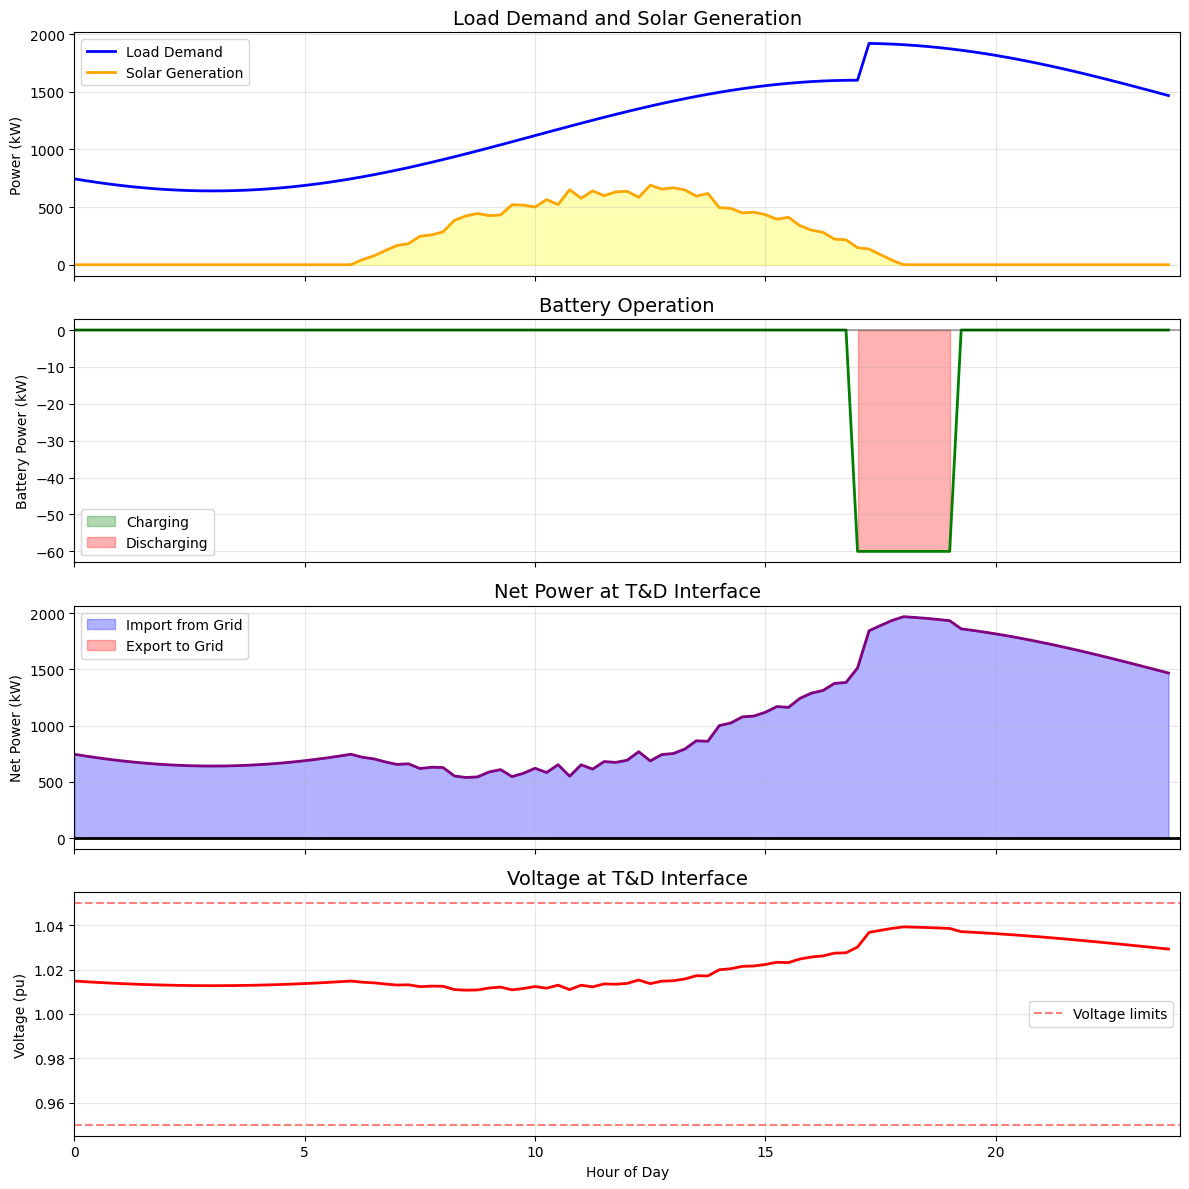


DER Impact Analysis Summary
Peak Load: 1919 kW
Peak Solar: 690 kW
Peak Net Export: -538 kW
Hours with Reverse Flow: 0.0 hours
Daily Solar Energy: 4801 kWh
Solar Penetration: 44%
Peak Reduction from Battery: -2.5%


In [7]:
# Simulate a day of DER operation to analyze impacts
def analyze_der_impacts():
    """
    Analyze the impacts of DERs on distribution system operation.
    """
    # Generate 24-hour profiles
    hours = np.arange(0, 24, 0.25)
    
    # Load profile (residential with evening peak)
    base_load = 1600  # kW
    load_shape = 0.7 + 0.3 * np.sin(np.pi * (hours - 10) / 14)
    load_shape[hours > 17] += 0.2  # Evening peak
    load_profile = base_load * load_shape
    
    # Solar generation profile
    solar_capacity = 700  # kW total
    solar_profile = np.zeros_like(hours)
    daylight = (hours >= 6) & (hours <= 18)
    solar_profile[daylight] = solar_capacity * np.sin(np.pi * (hours[daylight] - 6) / 12)
    
    # Add cloud variations
    np.random.seed(42)
    cloud_factor = 0.8 + 0.2 * np.random.random(len(hours))
    solar_profile *= cloud_factor
    
    # Battery operation (simple strategy)
    battery_power = np.zeros_like(hours)
    battery_soc = np.zeros_like(hours)
    soc = 0.5  # Initial SOC
    
    for i, hour in enumerate(hours):
        net_gen = solar_profile[i] - load_profile[i]
        
        if net_gen > 100 and soc < 0.9:  # Excess generation
            battery_power[i] = min(80, net_gen * 0.5)
        elif 17 <= hour <= 21 and soc > 0.2:  # Evening peak
            battery_power[i] = -60
        else:
            battery_power[i] = 0
            
        # Update SOC (simplified)
        soc += battery_power[i] * 0.25 / 400  # dt * power / capacity
        soc = np.clip(soc, 0.1, 0.9)
        battery_soc[i] = soc
    
    # Net power at substation
    net_power = load_profile - solar_profile - battery_power
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # Plot 1: Load and generation
    ax1 = axes[0]
    ax1.plot(hours, load_profile, 'b-', linewidth=2, label='Load Demand')
    ax1.plot(hours, solar_profile, 'orange', linewidth=2, label='Solar Generation')
    ax1.fill_between(hours, 0, solar_profile, alpha=0.3, color='yellow')
    ax1.set_ylabel('Power (kW)')
    ax1.set_title('Load Demand and Solar Generation', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Battery operation
    ax2 = axes[1]
    ax2.plot(hours, battery_power, 'g-', linewidth=2)
    ax2.fill_between(hours, 0, battery_power, where=battery_power>0,
                      alpha=0.3, color='green', label='Charging')
    ax2.fill_between(hours, 0, battery_power, where=battery_power<0,
                      alpha=0.3, color='red', label='Discharging')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.set_ylabel('Battery Power (kW)')
    ax2.set_title('Battery Operation', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Net power flow
    ax3 = axes[2]
    ax3.plot(hours, net_power, 'purple', linewidth=2)
    ax3.fill_between(hours, 0, net_power, where=net_power>0,
                      alpha=0.3, color='blue', label='Import from Grid')
    ax3.fill_between(hours, 0, net_power, where=net_power<0,
                      alpha=0.3, color='red', label='Export to Grid')
    ax3.axhline(y=0, color='k', linestyle='-', linewidth=2)
    ax3.set_ylabel('Net Power (kW)')
    ax3.set_title('Net Power at T&D Interface', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Voltage impact (simulated)
    ax4 = axes[3]
    # Simple voltage calculation based on power flow
    voltage_base = 1.0
    voltage_impact = voltage_base + 0.00002 * net_power  # Simplified
    ax4.plot(hours, voltage_impact, 'r-', linewidth=2)
    ax4.axhline(y=1.05, color='r', linestyle='--', alpha=0.5, label='Voltage limits')
    ax4.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Voltage (pu)')
    ax4.set_title('Voltage at T&D Interface', fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 24)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate key metrics
    print("\nDER Impact Analysis Summary")
    print("=" * 40)
    print(f"Peak Load: {load_profile.max():.0f} kW")
    print(f"Peak Solar: {solar_profile.max():.0f} kW")
    print(f"Peak Net Export: {-net_power.min():.0f} kW")
    print(f"Hours with Reverse Flow: {sum(net_power < 0) * 0.25:.1f} hours")
    print(f"Daily Solar Energy: {np.trapezoid(solar_profile, hours):.0f} kWh")
    print(f"Solar Penetration: {solar_capacity / base_load * 100:.0f}%")
    print(f"Peak Reduction from Battery: {(load_profile.max() - net_power.max()) / load_profile.max() * 100:.1f}%")

# Run the analysis
analyze_der_impacts()

## Real-World Applications and Case Studies

The co-simulation framework with DERs enables analysis of real-world scenarios that are increasingly common in modern power systems. Let's explore practical applications.

Case Study: High PV Penetration Analysis


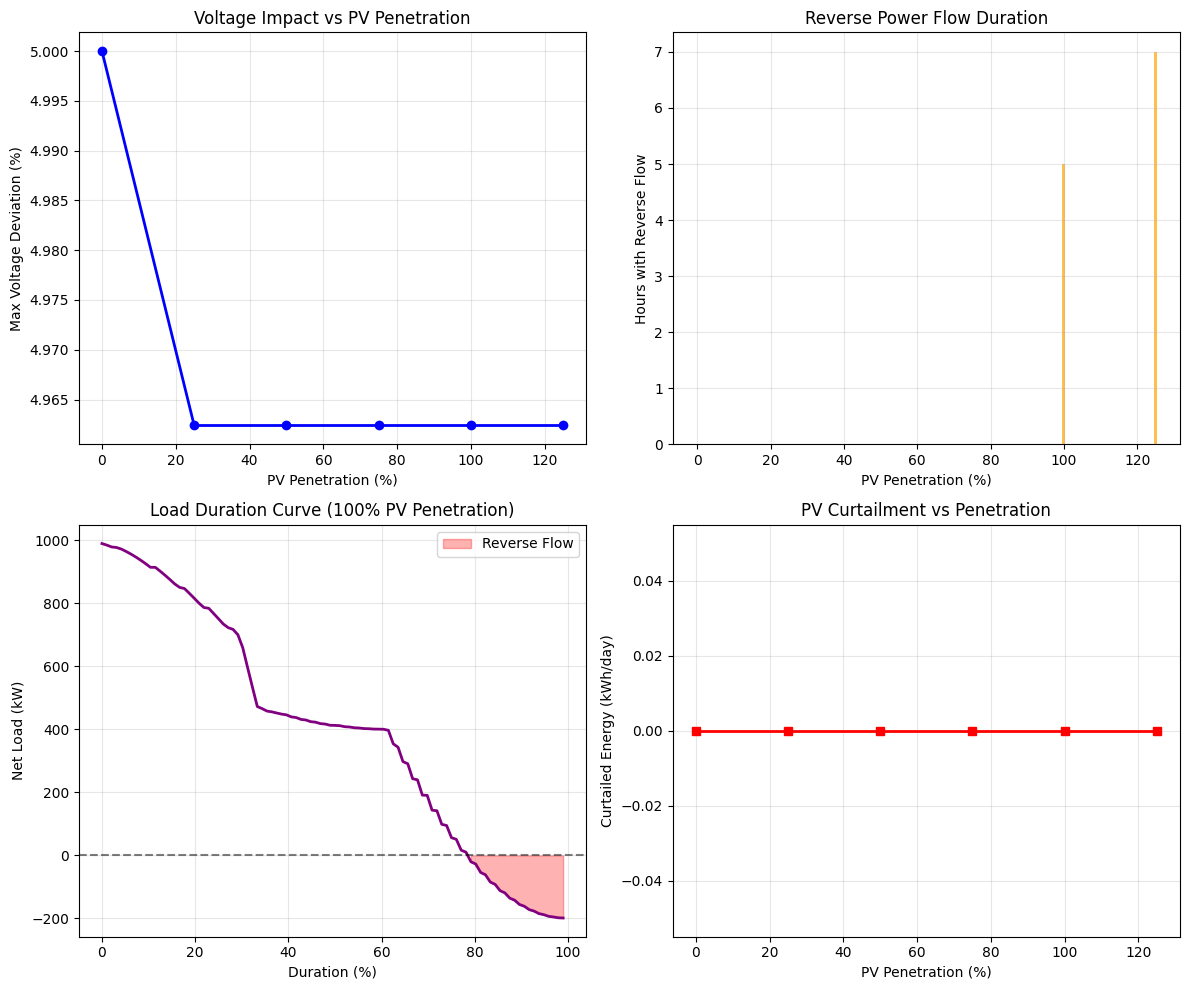


Key Findings:
1. Voltage issues begin at 50% penetration
2. Reverse flow occurs 5 hours/day at 100% penetration
3. Curtailment needed above 75% penetration
4. Battery storage could mitigate these issues by:
   - Absorbing midday excess generation
   - Supporting evening peak demand
   - Providing voltage regulation services


In [8]:
def case_study_high_pv_penetration():
    """
    Case study: Impact of high PV penetration on distribution system.
    """
    print("Case Study: High PV Penetration Analysis")
    print("=" * 50)
    
    # Analyze different penetration levels
    penetration_levels = [0, 25, 50, 75, 100, 125]  # Percentage of peak load
    results = {
        'penetration': [],
        'voltage_deviation': [],
        'reverse_flow_hours': [],
        'curtailment_energy': []
    }
    
    base_load = 1000  # kW
    
    for penetration in penetration_levels:
        pv_capacity = base_load * penetration / 100
        
        # Simple 24-hour simulation
        hours = np.arange(0, 24, 1)
        load = base_load * (0.7 + 0.3 * np.sin(np.pi * (hours - 10) / 14))
        
        # PV generation
        pv_gen = np.zeros_like(hours)
        daylight = (hours >= 6) & (hours <= 18)
        pv_gen[daylight] = pv_capacity * np.sin(np.pi * (hours[daylight] - 6) / 12)
        
        # Net load
        net_load = load - pv_gen
        
        # Simple voltage calculation
        voltage = 1.0 + 0.00005 * net_load
        voltage_dev = np.max(np.abs(voltage - 1.0))
        
        # Curtailment (if voltage too high)
        curtailment = np.where(voltage > 1.05, pv_gen * (voltage - 1.05) / 0.05, 0)
        
        # Store results
        results['penetration'].append(penetration)
        results['voltage_deviation'].append(voltage_dev * 100)  # Percentage
        results['reverse_flow_hours'].append(sum(net_load < 0))
        results['curtailment_energy'].append(sum(curtailment))
    
    # Visualize results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Voltage deviation
    ax1.plot(results['penetration'], results['voltage_deviation'], 'b-o', linewidth=2)
    ax1.set_xlabel('PV Penetration (%)')
    ax1.set_ylabel('Max Voltage Deviation (%)')
    ax1.set_title('Voltage Impact vs PV Penetration')
    ax1.grid(True, alpha=0.3)
    
    # Reverse flow hours
    ax2.bar(results['penetration'], results['reverse_flow_hours'], color='orange', alpha=0.7)
    ax2.set_xlabel('PV Penetration (%)')
    ax2.set_ylabel('Hours with Reverse Flow')
    ax2.set_title('Reverse Power Flow Duration')
    ax2.grid(True, alpha=0.3)
    
    # Load duration curve for 100% penetration
    pv_capacity = base_load
    hours_fine = np.linspace(0, 24, 96)
    load_fine = base_load * (0.7 + 0.3 * np.sin(np.pi * (hours_fine - 10) / 14))
    pv_gen_fine = np.zeros_like(hours_fine)
    daylight_fine = (hours_fine >= 6) & (hours_fine <= 18)
    pv_gen_fine[daylight_fine] = pv_capacity * np.sin(np.pi * (hours_fine[daylight_fine] - 6) / 12)
    net_load_fine = load_fine - pv_gen_fine
    
    # Sort for duration curve
    net_load_sorted = np.sort(net_load_fine)[::-1]
    duration = np.arange(len(net_load_sorted)) / len(net_load_sorted) * 100
    
    ax3.plot(duration, net_load_sorted, 'purple', linewidth=2)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.fill_between(duration, 0, net_load_sorted, where=net_load_sorted<0,
                      alpha=0.3, color='red', label='Reverse Flow')
    ax3.set_xlabel('Duration (%)')
    ax3.set_ylabel('Net Load (kW)')
    ax3.set_title('Load Duration Curve (100% PV Penetration)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Curtailment energy
    ax4.plot(results['penetration'], results['curtailment_energy'], 'r-s', linewidth=2)
    ax4.set_xlabel('PV Penetration (%)')
    ax4.set_ylabel('Curtailed Energy (kWh/day)')
    ax4.set_title('PV Curtailment vs Penetration')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Findings:")
    print(f"1. Voltage issues begin at {penetration_levels[2]}% penetration")
    print(f"2. Reverse flow occurs {results['reverse_flow_hours'][4]} hours/day at 100% penetration")
    print(f"3. Curtailment needed above {penetration_levels[3]}% penetration")
    print("4. Battery storage could mitigate these issues by:")
    print("   - Absorbing midday excess generation")
    print("   - Supporting evening peak demand")
    print("   - Providing voltage regulation services")

# Run case study
case_study_high_pv_penetration()

## Summary and Future Directions

This lesson demonstrated how distributed energy resources fundamentally change power system operation and the critical role of co-simulation in analyzing these changes. Key takeaways include:

### Technical Insights

1. **Bidirectional Power Flow**: DERs can cause distribution systems to export power to transmission, requiring new protection and control strategies.

2. **Voltage Regulation Challenges**: High DER penetration can cause voltage rise during low load periods, potentially requiring curtailment or advanced inverter controls.

3. **Coordination Opportunities**: Battery storage can mitigate solar intermittency while providing multiple grid services including peak shaving and frequency regulation.

### Co-simulation Value

The integrated T&D co-simulation with DERs enables analyses impossible with traditional tools:
- Capturing transmission system impacts of distributed generation
- Evaluating distribution hosting capacity considering transmission constraints
- Optimizing DER dispatch for system-wide benefits

### Future Applications

The framework developed here extends to many emerging grid challenges:
- Electric vehicle integration and vehicle-to-grid services
- Microgrid formation and islanding studies
- Resilience analysis with DER black-start capabilities
- Market integration for DER participation in wholesale markets

As power systems continue evolving toward distributed, renewable, and interactive grids, co-simulation becomes an essential tool for planning and operations. The skills you've developed in this module provide a foundation for addressing the complex challenges of tomorrow's power systems.